# Deep Learning

## Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import csv
import pandas as pd
import numpy as np
import sys

GOOGLE_DRIVE_PATH_POST_MYDRIVE = 'dl-twitter-crisis'
GOOGLE_DRIVE_PATH = os.path.join('/content', 'drive', 'MyDrive', GOOGLE_DRIVE_PATH_POST_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

if 'google.colab' in sys.modules:
  print(f'Running in google colab. Our path is `{GOOGLE_DRIVE_PATH}`')
else:
  GOOGLE_DRIVE_PATH = '.'
  print('Running locally.')

print(GOOGLE_DRIVE_PATH)
sys.path.append(GOOGLE_DRIVE_PATH)

['anomaly_detection.ipynb', 'anomaly_detection_local.ipynb', 'crisis_bench_preprocess.ipynb', 'crisis_bench_local.ipynb', 'overleaf.tex', 'best_textcnn_glove.pt', 'cnn_acc_curve.png', 'cnn_num_filters_validation_curve.png', 'nltk_data', 'docs', 'transformers', '.ipynb_checkpoints', 'paper', 'data', '.git', '.DS_Store', 'README.md', '.gitignore', 'environment.yml', 'textcnn_results.csv', 'textcnn_results2.csv', 'cnn_f1_score_curve.png', 'cnn_loss_curve.png', 'transformer_learning_curve_f1.png', 'transformer_lr_validation_curve_f1.png', 'textcnn_learning_curve_best_num_filters_75.png', 'textcnn_learning_curve_best_100.png', 'textcnn_learning_curve_best_75.png', 'textcnn_learning_curves_by_num_filters.png', 'best_textcnn_glove_numfilters_25.pt', 'best_textcnn_glove_numfilters_50.pt', 'best_textcnn_glove_numfilters_75.pt', 'best_textcnn_glove_numfilters_100.pt', 'textcnn_learning_curve_best_50.png', 'textcnn_validation_curve_num_filters.png', 'best_custom_transformer_lr.pt', 'custom_transf

In [3]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score

In [4]:
import random

SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

generator = torch.Generator()
_ = generator.manual_seed(SEED)

In [5]:
all_label_strs = ['time_critical', 'support_and_relief', 'non_informative']
label2id = {label: i for i, label in enumerate(all_label_strs)}
id2label = {i: label for label, i in label2id.items()}

In [6]:
def load_data():
    df = {}
    for d in ['train', 'dev', 'test']:
        output_path = GOOGLE_DRIVE_PATH + f"/data/crisisbench/preprocessed_data_{d}.csv"
        df[d] = pd.read_csv(output_path).loc[:, ['text', 'class_label_group', 'class_label_group_num']]
        print("Loading:", output_path)
    return df

df = load_data()

Loading: /content/drive/MyDrive/dl-twitter-crisis/data/crisisbench/preprocessed_data_train.csv
Loading: /content/drive/MyDrive/dl-twitter-crisis/data/crisisbench/preprocessed_data_dev.csv
Loading: /content/drive/MyDrive/dl-twitter-crisis/data/crisisbench/preprocessed_data_test.csv


In [14]:
print(f"df_train: N={len(df['train'])}")
df['train'].head()

df_train: N=61089


,text,class_label_group,class_label_group_num
0,approximately km long firebreaks have been con...,time_critical,0
1,god bless you,non_informative,2
2,cracked wine casks damaged historical building...,time_critical,0
3,i m really just excited for new undies and pin...,non_informative,2
4,rescue effort e ands in india pakistan as floo...,time_critical,0


In [ ]:
print(f"df_dev: N={len(df['dev'])}")
df['dev'].head()

df_dev: N=8921


,text,class_label_group,class_label_group_num
0,congrats to all my liverpool supporting fans f...,non_informative,2
1,collapsed buildings in mexico city earthquake ...,time_critical,0
2,here s your flower,non_informative,2
3,ready for a relaxing weekend but have too much...,non_informative,2
4,public private information portal developed to...,support_and_relief,1


In [ ]:
print(f"df_test: N={len(df['test'])}")
df['test'].head()

df_test: N=17335


,text,class_label_group,class_label_group_num
0,staff at our feeding centre say chronic malnou...,support_and_relief,1
1,you comin down for the summer semesters right,non_informative,2
2,yea it s upstate i m like a few hours away,non_informative,2
3,teach every pakistani that it is not enough to...,non_informative,2
4,stay with for live cvg as typhoon hagupit slam...,time_critical,0


## CNN

### CNN Paper Setup
We train the CNN models using the Adam optimizer (Kingma and Ba 2014). The batch size is 128 and maximum number of epochs is set to 1000. We use a filter size of 300 with both window size and pooling length of 2, 3, and 4, and a dropout rate 0.02. We set early stopping
criterion based on the accuracy of the development set with a patience of 200.

### Import Libraries

In [7]:

import math
from collections import Counter
from typing import List, Tuple, Dict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader


### Hyperparameters

In [8]:
MAX_VOCAB_SIZE = 5000
MAX_SEQ_LEN = 64 # depends on tweet length
EMBED_DIM = 50
FILTER_SIZES = (3, 4, 5)
NUM_FILTERS = 50
DROPOUT = 0.5 # tune
BATCH_SIZE = 64 # tune
LR = 1e-3
NUM_EPOCHS = 5
PAD_TOKEN = "<pad>"
UNK_TOKEN = "<unk>"
GLOVE_PATH = GOOGLE_DRIVE_PATH + "/data/crisisbench/glove_word_embeddings.txt"

### Tokenizer and Vocab

In [23]:
def simple_tokenize(text: str) -> List[str]:
    """
    Splits on whitespace
    """
    return text.strip().split()

def build_vocab(
    texts: List[str],
    max_size: int,
    min_freq: int = 1
) -> Dict[str, int]:
    """
    Build a word -> index vocab from training texts.
    Reserves index 0 for PAD and 1 for UNK.
    """
    counter = Counter()
    for text in texts:
        tokens = simple_tokenize(text)
        counter.update(tokens)

    vocab = {PAD_TOKEN: 0, UNK_TOKEN: 1}
    for word, freq in counter.most_common():
        if freq < min_freq:
            continue
        if len(vocab) >= max_size:
            break
        vocab[word] = len(vocab)

    return vocab


def encode_text(
    text: str,
    vocab: Dict[str, int],
    max_len: int
) -> List[int]:
    tokens = simple_tokenize(text)
    ids = [vocab.get(tok, vocab[UNK_TOKEN]) for tok in tokens][:max_len]
    if len(ids) < max_len:
        ids += [vocab[PAD_TOKEN]] * (max_len - len(ids))
    return ids


### Dataset & DataLoader

In [24]:
class TextDataset(Dataset):
    def __init__(
        self,
        texts: List[str],
        labels: List[int],
        vocab: Dict[str, int],
        max_len: int,
    ):
        assert len(texts) == len(labels)
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        self.max_len = max_len

    def __len__(self) -> int:
        return len(self.texts)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int]:
        text = self.texts[idx]
        label = self.labels[idx]
        input_ids = encode_text(text, self.vocab, self.max_len)
        return torch.tensor(input_ids, dtype=torch.long), label


def create_dataloaders(
    train_texts: List[str],
    train_labels: List[int],
    val_texts: List[str],
    val_labels: List[int],
    max_vocab_size: int,
    max_seq_len: int,
    batch_size: int,
) -> Tuple[DataLoader, DataLoader, Dict[str, int], int]:
    vocab = build_vocab(train_texts, max_vocab_size)
    num_classes = len(set(train_labels))

    train_dataset = TextDataset(train_texts, train_labels, vocab, max_seq_len)
    val_dataset = TextDataset(val_texts, val_labels, vocab, max_seq_len)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, vocab, num_classes


### Load GloVe & build embedding matrix

In [25]:
def load_glove_embeddings(
    glove_path: str,
    embed_dim: int,
) -> Dict[str, torch.Tensor]:
    """
    Load GloVe file into a dict: word -> vector (torch.Tensor).
    Expects each line: word val1 val2 ... valD
    """
    embeddings = {}
    with open(glove_path, "r", encoding="utf8") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != embed_dim + 1:
                # ignore malformed lines
                continue
            word = parts[0]
            vec = torch.tensor([float(x) for x in parts[1:]], dtype=torch.float32)
            embeddings[word] = vec
    return embeddings


def build_embedding_matrix(
    vocab: Dict[str, int],
    glove_embeddings: Dict[str, torch.Tensor],
    embed_dim: int,
) -> torch.Tensor:
    """
    Create an embedding matrix of shape [vocab_size, embed_dim]
    where row i is the vector for the word with index i.
    Words not found in GloVe are randomly initialized (small normal).
    """
    vocab_size = len(vocab)
    embedding_matrix = torch.empty(vocab_size, embed_dim, dtype=torch.float32)

    # Initialize OOV embeddings to small random values
    torch.nn.init.normal_(embedding_matrix, mean=0.0, std=0.05)

    # Set PAD embedding to zeros
    pad_idx = vocab[PAD_TOKEN]
    embedding_matrix[pad_idx] = torch.zeros(embed_dim, dtype=torch.float32)

    oov_count = 0
    for word, idx in vocab.items():
        if word in (PAD_TOKEN, UNK_TOKEN):
            continue
        vec = glove_embeddings.get(word)
        if vec is not None:
            embedding_matrix[idx] = vec
        else:
            oov_count += 1

    print(f"GloVe OOV words: {oov_count}/{vocab_size}")
    return embedding_matrix

### Text CNN model (with optional pretrained embeddings)

In [26]:
class TextCNN(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        embed_dim: int,
        num_classes: int,
        pad_idx: int = 0,
        num_filters: int = 100,
        filter_sizes: Tuple[int, ...] = (3, 4, 5),
        dropout: float = 0.5,
        pretrained_embeddings: torch.Tensor | None = None,
        freeze_embeddings: bool = False,
    ):
        super().__init__()

        self.embedding = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embed_dim,
            padding_idx=pad_idx,
        )

        if pretrained_embeddings is not None:
            if pretrained_embeddings.shape != (vocab_size, embed_dim):
                raise ValueError(
                    f"Pretrained embeddings shape {pretrained_embeddings.shape} "
                    f"does not match (vocab_size, embed_dim)=({vocab_size}, {embed_dim})"
                )
            self.embedding.weight.data.copy_(pretrained_embeddings)
            if freeze_embeddings:
                self.embedding.weight.requires_grad = False

        self.convs = nn.ModuleList([
            nn.Conv1d(
                in_channels=embed_dim,
                out_channels=num_filters,
                kernel_size=fs,
            )
            for fs in filter_sizes
        ])

        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(num_filters * len(filter_sizes), num_classes)

    def forward(self, input_ids: torch.Tensor) -> torch.Tensor:
        embedded = self.embedding(input_ids)          # [B, L, D]
        embedded = embedded.transpose(1, 2)           # [B, D, L]

        conv_outputs = []
        for conv in self.convs:
            x = conv(embedded)                        # [B, F, L']
            x = F.relu(x)
            x = F.max_pool1d(x, x.size(2)).squeeze(2) # [B, F]
            conv_outputs.append(x)

        cat = torch.cat(conv_outputs, dim=1)          # [B, F * len(filter_sizes)]
        cat = self.dropout(cat)
        logits = self.fc(cat)                         # [B, num_classes]
        return logits

### Training & Evaluation

In [27]:
def train_one_epoch(
    model: nn.Module,
    dataloader: DataLoader,
    optimizer: torch.optim.Optimizer,
    criterion: nn.Module,
    device: torch.device,
):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    all_preds = []
    all_targets = []

    for input_ids, labels in dataloader:
        input_ids = input_ids.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        logits = model(input_ids)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * input_ids.size(0)

        preds = logits.argmax(dim=1)

        # accumulate predictions & ground truth
        all_preds.extend(preds.cpu().tolist())
        all_targets.extend(labels.cpu().tolist())

        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / total
    accuracy = correct / total if total > 0 else 0.0

    return avg_loss, accuracy, all_preds, all_targets


def evaluate(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_examples = 0

    all_preds = []
    all_targets = []

    with torch.no_grad():
        for x, y in data_loader:
            x, y = x.to(device), y.to(device)

            logits = model(x)
            loss = criterion(logits, y)

            preds = logits.argmax(dim=1)

            total_loss += loss.item() * x.size(0)
            total_correct += (preds == y).sum().item()
            total_examples += x.size(0)

            all_preds.extend(preds.cpu().tolist())
            all_targets.extend(y.cpu().tolist())

    avg_loss = total_loss / total_examples
    avg_acc = total_correct / total_examples

    return avg_loss, avg_acc, all_preds, all_targets



### Main CNN Train Script

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Create loaders and vocab
train_loader, val_loader, vocab, num_classes = create_dataloaders(
    train_texts=df['train']['text'].to_list(),
    train_labels=df['train']['class_label_group_num'],
    val_texts=df['dev']['text'].to_list(),
    val_labels=df['dev']['class_label_group_num'],
    max_vocab_size=MAX_VOCAB_SIZE,
    max_seq_len=MAX_SEQ_LEN,
    batch_size=BATCH_SIZE,
)

# print(f"Vocab size: {len(vocab)}, Num classes: {num_classes}")

# # Load GloVe embeddings
print("Loading GloVe embeddings...")
glove_embeds = load_glove_embeddings(GLOVE_PATH, EMBED_DIM)
embedding_matrix = build_embedding_matrix(vocab, glove_embeds, EMBED_DIM)

# # Initialize model with pretrained embeddings
# print("Model Initialization...")
# model = TextCNN(
#     vocab_size=len(vocab),
#     embed_dim=EMBED_DIM,
#     num_classes=num_classes,
#     pad_idx=vocab[PAD_TOKEN],
#     num_filters=NUM_FILTERS,
#     filter_sizes=FILTER_SIZES,
#     dropout=DROPOUT,
#     pretrained_embeddings=embedding_matrix,
#     freeze_embeddings=False,   # set True if you want to freeze GloVe
# ).to(device)

# optimizer = torch.optim.Adam(model.parameters(), lr=LR)
# criterion = nn.CrossEntropyLoss()

# best_val_f1 = 0.0

# train_losses = []
# train_accs = []
# train_f1s = []
# val_losses = []
# val_accs = []
# val_f1s = []

# print("Training...")
# for epoch in range(1, NUM_EPOCHS + 1):
#     train_loss, train_acc, train_preds, train_targets = train_one_epoch(
#         model, train_loader, optimizer, criterion, device
#     )
#     train_f1 = f1_score(train_targets, train_preds, average="macro")
#     train_f1s.append(train_f1)
#     val_loss, val_acc, val_preds, val_targets = evaluate(
#         model, val_loader, criterion, device
#     )
#     val_f1 = f1_score(val_targets, val_preds, average="macro")
#     val_f1s.append(val_f1)

#     train_losses.append(train_loss)
#     train_accs.append(train_acc)
#     val_losses.append(val_loss)
#     val_accs.append(val_acc)

#     if val_f1 > best_val_f1:
#         best_val_f1 = val_f1
#         torch.save(model.state_dict(), "cnn/best_textcnn_glove.pt")

#     print(
#         f"Epoch {epoch:02d} | "
#         f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Train F1: {train_f1:.4f} | "
#         f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}"
#     )

# print(f"Best validation f1: {best_val_f1:.4f}")

Loading GloVe embeddings...
GloVe OOV words: 58/5000


### Calculate Test Metrics

In [32]:
from sklearn.metrics import f1_score

# --------- load best model ---------
best_ckpt_path = b=GOOGLE_DRIVE_PATH + f"/best_textcnn_glove_numfilters_50.pt"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Create loaders and vocab
train_loader, val_loader, vocab, num_classes = create_dataloaders(
    train_texts=df['train']['text'].to_list(),
    train_labels=df['train']['class_label_group_num'],
    val_texts=df['dev']['text'].to_list(),
    val_labels=df['dev']['class_label_group_num'],
    max_vocab_size=MAX_VOCAB_SIZE,
    max_seq_len=MAX_SEQ_LEN,
    batch_size=BATCH_SIZE,
)

print("Loading GloVe embeddings...")
glove_embeds = load_glove_embeddings(GLOVE_PATH, EMBED_DIM)
embedding_matrix = build_embedding_matrix(vocab, glove_embeds, EMBED_DIM)

criterion = nn.CrossEntropyLoss()


# Rebuild model with best num_filters
model = TextCNN(
    vocab_size=5000,
    embed_dim=EMBED_DIM,
    num_classes=3,
    pad_idx=vocab[PAD_TOKEN],
    num_filters=50,
    filter_sizes=FILTER_SIZES,
    dropout=DROPOUT,
    pretrained_embeddings=embedding_matrix,
    freeze_embeddings=False,
).to(device)
model.load_state_dict(torch.load(best_ckpt_path, map_location=device))

best_optimizer = torch.optim.Adam(model.parameters(), lr=LR)
# model.load_state_dict(torch.load("cnn/best_textcnn_glove.pt", map_location=device))
# model.to(device)

# --------- build test loader ---------
test_dataset = TextDataset(
    texts=df['test']['text'].to_list(),
    labels=df['test']['class_label_group_num'],
    vocab=vocab,
    max_len=MAX_SEQ_LEN,
)

cnn_test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

# --------- test loss + accuracy + preds ---------
test_loss, test_acc, test_preds, test_targets = evaluate(
    model, cnn_test_loader, criterion, device
)
print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

# --------- compute ONLY F1 (macro) ---------
test_f1 = f1_score(test_targets, test_preds, average="macro")
print(f"Test F1 (macro): {test_f1:.4f}")


Loading GloVe embeddings...
GloVe OOV words: 58/5000
Test Loss: 0.3681, Test Acc: 0.8694
Test F1 (macro): 0.8255


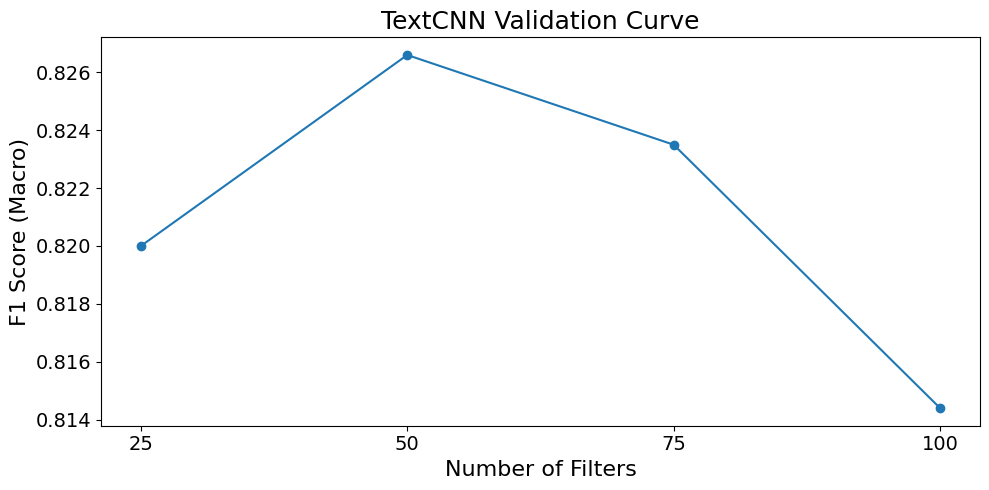


Reloading best model: num_filters=50, ckpt=/content/drive/MyDrive/dl-twitter-crisis/best_textcnn_glove_numfilters_50.pt


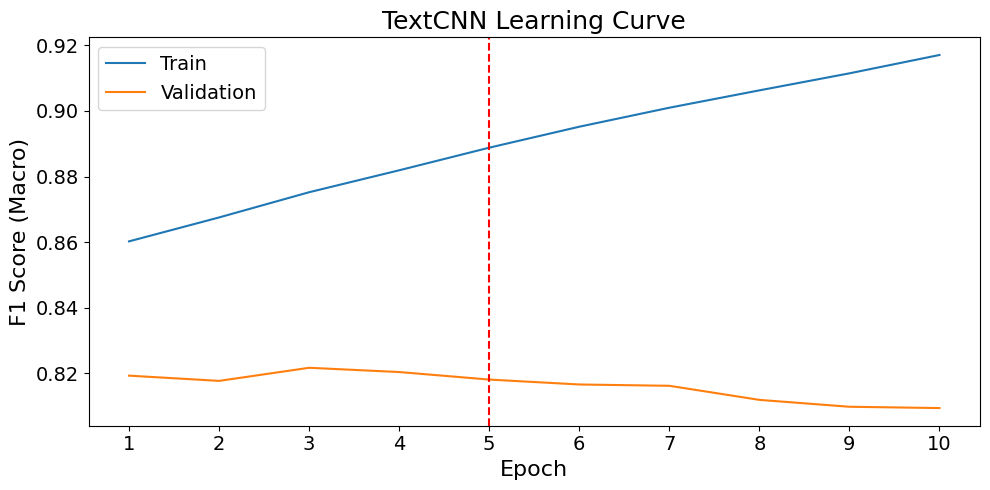

In [ ]:
import os
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ------------------------------------------------
# 0. Data loaders + GloVe + loss
# ------------------------------------------------
# train_loader, val_loader, vocab, num_classes = create_dataloaders(
#     train_texts=df['train']['text'].to_list(),
#     train_labels=df['train']['class_label_group_num'],
#     val_texts=df['dev']['text'].to_list(),
#     val_labels=df['dev']['class_label_group_num'],
#     max_vocab_size=MAX_VOCAB_SIZE,
#     max_seq_len=MAX_SEQ_LEN,
#     batch_size=BATCH_SIZE,
# )

# print(f"Vocab size: {len(vocab)}, Num classes: {num_classes}")

# print("Loading GloVe embeddings...")
# glove_embeds = load_glove_embeddings(GLOVE_PATH, EMBED_DIM)
# embedding_matrix = build_embedding_matrix(vocab, glove_embeds, EMBED_DIM)

# criterion = nn.CrossEntropyLoss()

# ------------------------------------------------
# 1. Hyperparameter sweep over num_filters
# ------------------------------------------------
# num_filters_list = [25, 50, 75, 100]
# max_epochs_cap = 10

# results = {}  # num_filters -> dict

# best_overall_f1 = -1.0
# best_overall_cfg = None

# for num_filters in num_filters_list:
#     print("\n" + "=" * 60)
#     print(f"Training TextCNN with num_filters={num_filters}")
#     print("=" * 60)

#     model = TextCNN(
#         vocab_size=len(vocab),
#         embed_dim=EMBED_DIM,
#         num_classes=num_classes,
#         pad_idx=vocab[PAD_TOKEN],
#         num_filters=num_filters,
#         filter_sizes=FILTER_SIZES,
#         dropout=DROPOUT,
#         pretrained_embeddings=embedding_matrix,
#         freeze_embeddings=False,
#     ).to(device)

#     optimizer = torch.optim.Adam(model.parameters(), lr=LR)

#     train_f1s = []
#     val_f1s = []
#     best_val_f1 = -1.0
#     best_epoch = 0

#     ckpt_path = GOOGLE_DRIVE_PATH + f"/best_textcnn_glove_numfilters_{num_filters}.pt"

#     for epoch in range(1, max_epochs_cap + 1):
#         # ---- Train one epoch ----
#         train_loss, train_acc, train_preds, train_targets = train_one_epoch(
#             model, train_loader, optimizer, criterion, device
#         )
#         train_f1 = f1_score(train_targets, train_preds, average="macro")

#         # ---- Validation ----
#         val_loss, val_acc, val_preds, val_targets = evaluate(
#             model, val_loader, criterion, device
#         )
#         val_f1 = f1_score(val_targets, val_preds, average="macro")

#         train_f1s.append(train_f1)
#         val_f1s.append(val_f1)

#         print(
#             f"[num_filters={num_filters}] "
#             f"Epoch {epoch:02d} | "
#             f"Train Loss: {train_loss:.4f}, Train F1: {train_f1:.4f} | "
#             f"Val Loss: {val_loss:.4f}, Val F1: {val_f1:.4f}"
#         )

#         # update best for this num_filters
#         if val_f1 > best_val_f1:
#             best_val_f1 = val_f1
#             best_epoch = epoch
#             torch.save(model.state_dict(), ckpt_path)
#         # simple overfitting signal: first time val_f1 drops below best
#         elif val_f1 < best_val_f1:
#             print(
#                 f"Overfitting signal detected at epoch {epoch} "
#                 f"(prev best val F1={best_val_f1:.4f} at epoch {best_epoch})"
#             )
#             break

#     results[num_filters] = {
#         "train_f1s": train_f1s,
#         "val_f1s": val_f1s,
#         "best_val_f1": best_val_f1,
#         "best_epoch": best_epoch,
#         "ckpt_path": ckpt_path,
#     }

#     # track global best across all num_filters
#     if best_val_f1 > best_overall_f1:
#         best_overall_f1 = best_val_f1
#         best_overall_cfg = {
#             "num_filters": num_filters,
#             "ckpt_path": ckpt_path,
#             "best_epoch": best_epoch,
#         }

# print("\n=== Sweep complete ===")
# print(f"Best overall num_filters: {best_overall_cfg['num_filters']} "
#       f"(val F1={best_overall_f1:.4f} at epoch={best_overall_cfg['best_epoch']})")


# ------------------------------------------------
# 2. Validation curve: num_filters vs best validation F1
#    + hard-coded list of best F1s
# ------------------------------------------------
# best_f1s = [results[nf]["best_val_f1"] for nf in num_filters_list]
best_f1s = [0.82, 0.8266, 0.8235, 0.8144]

# After you run once and see the values, you can hard-code them, e.g.:

plt.figure(figsize=(10, 5))
plt.plot([25,50,75,100], best_f1s, marker="o")
plt.xlabel("Number of Filters", fontsize=16)
plt.ylabel("F1 Score (Macro)", fontsize=16)
plt.xticks([25,50,75,100], fontsize=14)
plt.yticks(fontsize=14)
plt.title("TextCNN Validation Curve", fontsize=18)
plt.tight_layout()
plt.savefig(GOOGLE_DRIVE_PATH + "/textcnn_validation_curve_num_filters.png")
plt.show()

# ------------------------------------------------
# 3. Using the best model config, load checkpoint and
#    plot learning curve for 10 epochs (Train + Val F1)
# ------------------------------------------------
best_num_filters = 50
best_ckpt_path = b=GOOGLE_DRIVE_PATH + f"/best_textcnn_glove_numfilters_{best_num_filters}.pt"

print(f"\nReloading best model: num_filters={best_num_filters}, ckpt={best_ckpt_path}")

# Rebuild model with best num_filters
# best_model = TextCNN(
#     vocab_size=len(vocab),
#     embed_dim=EMBED_DIM,
#     num_classes=num_classes,
#     pad_idx=vocab[PAD_TOKEN],
#     num_filters=best_num_filters,
#     filter_sizes=FILTER_SIZES,
#     dropout=DROPOUT,
#     pretrained_embeddings=embedding_matrix,
#     freeze_embeddings=False,
# ).to(device)

# best_model.load_state_dict(torch.load(best_ckpt_path, map_location=device))

# best_optimizer = torch.optim.Adam(best_model.parameters(), lr=LR)

final_train_f1s = []
final_val_f1s = []
EPOCHS_FOR_CURVE = 10
epochs = [1,2,3,4,5,6,7,8,9,10]

# print("\nTraining best configuration for 10 epochs to plot learning curve...")
# for epoch in range(1, EPOCHS_FOR_CURVE + 1):
#     best_model.train()
#     train_loss, train_acc, train_preds, train_targets = train_one_epoch(
#         best_model, train_loader, best_optimizer, criterion, device
#     )
#     train_f1 = f1_score(train_targets, train_preds, average="macro")

#     val_loss, val_acc, val_preds, val_targets = evaluate(
#         best_model, val_loader, criterion, device
#     )
#     val_f1 = f1_score(val_targets, val_preds, average="macro")

#     final_train_f1s.append(train_f1)
#     final_val_f1s.append(val_f1)

#     print(
#         f"[BEST num_filters={best_num_filters}] "
#         f"Epoch {epoch:02d} | "
#         f"Train Loss: {train_loss:.4f}, Train F1: {train_f1:.4f} | "
#         f"Val Loss: {val_loss:.4f}, Val F1: {val_f1:.4f}"
#     )

final_val_f1s = [0.8192, 0.8176, 0.8216, 0.8203, 0.8180, 0.8165, 0.8161, 0.8118, 0.8097, 0.8093]
final_train_f1s = [0.8602, 0.8675, 0.8752, 0.8819, 0.8888, 0.8952, 0.9010, 0.9063, 0.9115, 0.9171]
# Plot learning curve (train + val F1) for best configuration
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(final_val_f1s)+1), final_train_f1s, label="Train")
plt.plot(range(1, len(final_val_f1s)+1), final_val_f1s, label="Validation")
plt.xticks([i for i in range(1, len(final_val_f1s)+1)], fontsize=14)
plt.axvline(x=5, color='red', linestyle='--', linewidth=1.5)
plt.yticks(fontsize=14)
plt.xlabel("Epoch", fontsize=16)
plt.ylabel("F1 Score (Macro)", fontsize=16)
plt.title(f"TextCNN Learning Curve", fontsize=18)
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig(GOOGLE_DRIVE_PATH + f"/textcnn_learning_curve_best_{best_num_filters}.png")
plt.show()


## Transformer

### Model

In [54]:
import math
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class TransformerClassifier(nn.Module):
    def __init__(
        self,
        vocab_size,
        num_labels = 3,
        max_length = 64,
        d_model = 256, # hidden size
        nhead = 4, # number of attention heads
        num_layers = 2, # number of encoder layers
        dim_feedforward = 512,  # FFN inner dim
        dropout = 0.3,
    ):
        super().__init__()
        self.d_model = d_model
        self.max_length = max_length

        self.token_embedding = nn.Embedding(vocab_size, d_model)
        self.pos_embedding = nn.Embedding(max_length, d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True, # (batch, seq, dim)
        )
        self.encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers,
        )
        self.layer_norm = nn.LayerNorm(d_model)
        self.classifier = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, num_labels),
        )

    def forward(self, input_ids, attention_mask):
        batch_size, seq_len = input_ids.size()
        if seq_len > self.max_length:
            raise ValueError(f"seq_len {seq_len} > max_length {self.max_length}")

        token_emb = self.token_embedding(input_ids)  # (B, L, D)

        positions = torch.arange(seq_len, device=input_ids.device).unsqueeze(0)  # (1, L)
        pos_emb = self.pos_embedding(positions)  # (1, L, D)

        x = token_emb + pos_emb  # (B, L, D)

        src_key_padding_mask = (attention_mask == 0)  # (B, L), bool

        x = self.encoder(x, src_key_padding_mask=src_key_padding_mask)  # (B, L, D)
        x = self.layer_norm(x)

        mask = attention_mask.unsqueeze(-1)  # (B, L, 1)
        masked_x = x * mask  # (B, L, D)

        lengths = mask.sum(dim=1).clamp(min=1)  # (B, 1)
        pooled = masked_x.sum(dim=1) / lengths  # (B, D)

        logits = self.classifier(pooled)  # (B, num_labels)
        return logits

In [55]:
def compute_metrics_from_preds(all_logits, all_labels):
    logits = np.concatenate(all_logits, axis=0)
    labels = np.concatenate(all_labels, axis=0)

    preds = np.argmax(logits, axis=-1)

    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels,
        preds,
        average="macro",
        zero_division=0,
    )
    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

### Tokenizer

In [60]:
!pip install datasets
from tokenizers import Tokenizer, models, trainers, pre_tokenizers
from datasets import Dataset, DatasetDict

train_texts = df["train"]["text"].tolist()
dev_texts   = df["dev"]["text"].tolist()
test_texts   = df["test"]["text"].tolist()

tokenizer = Tokenizer(models.BPE(unk_token="[UNK]"))
tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()

special_tokens = ["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"]
trainer = trainers.BpeTrainer(
    vocab_size=30000, # could be adjusted
    min_frequency=2,
    special_tokens=special_tokens,
)

tokenizer.train_from_iterator(train_texts, trainer=trainer)

max_length = 64
pad_id = tokenizer.token_to_id("[PAD]")

tokenizer.enable_truncation(max_length=max_length)
tokenizer.enable_padding(
    length=max_length,
    pad_id=pad_id,
    pad_token="[PAD]",
)

def encode_batch(texts):
    encodings = tokenizer.encode_batch(texts)
    input_ids = [e.ids for e in encodings]
    attention_mask = [e.attention_mask for e in encodings]
    return {"input_ids": input_ids, "attention_mask": attention_mask}

train_enc = encode_batch(train_texts)
dev_enc   = encode_batch(dev_texts)
test_enc   = encode_batch(test_texts)

train_dataset = Dataset.from_dict({
    "input_ids":      train_enc["input_ids"],
    "attention_mask": train_enc["attention_mask"],
    "label":          df["train"]["class_label_group_num"].tolist(),
    "text":           df["train"]["text"].tolist(),
})
val_dataset = Dataset.from_dict({
    "input_ids":      dev_enc["input_ids"],
    "attention_mask": dev_enc["attention_mask"],
    "label":          df["dev"]["class_label_group_num"].tolist(),
    "text":           df["dev"]["text"].tolist(),
})
test_dataset = Dataset.from_dict({
    "input_ids":      test_enc["input_ids"],
    "attention_mask": test_enc["attention_mask"],
    "label":          df["test"]["class_label_group_num"].tolist(),
    "text":           df["test"]["text"].tolist(),
})

tokenized_datasets = DatasetDict({
    "train": train_dataset,
    "validation": val_dataset,
    "test": test_dataset,
})

tokenized_datasets.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "label", "text"],
)

### Plot Curves Using Best Model


=== Training learning-curve model from best LR ===
Reloading best LR=None and model from /content/drive/MyDrive/dl-twitter-crisis/best_custom_transformer_lr.pt

Test Metrics (Best LR=None):
  Test Loss: 0.4080
  Test Accuracy: 0.8545
  Test Precision: 0.8204
  Test Recall: 0.7807
  Test F1 (macro): 0.7980


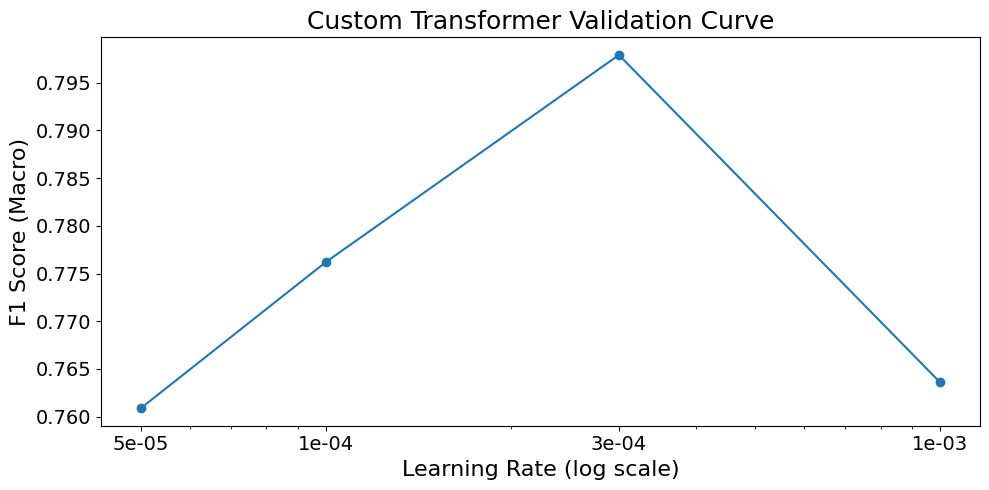

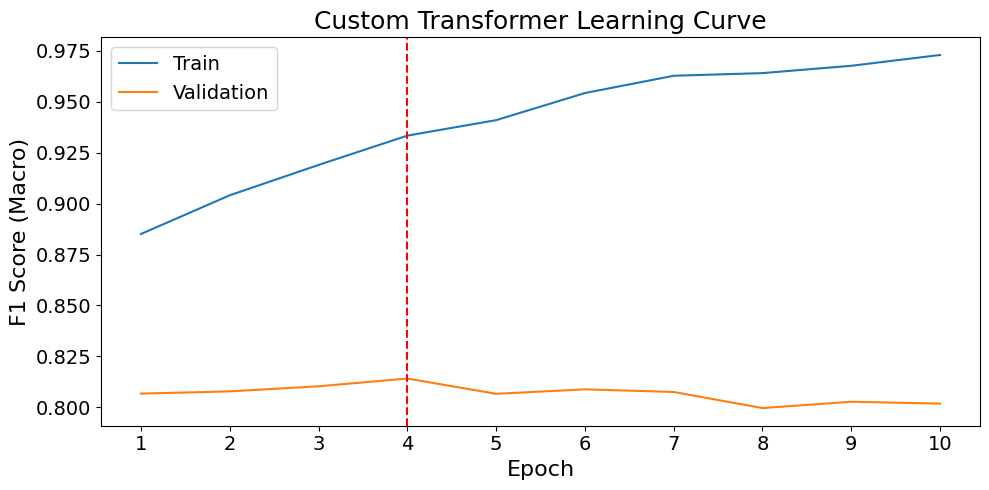

In [68]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from torch.optim import AdamW


import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.optim import AdamW
from sklearn.metrics import f1_score

criterion = nn.CrossEntropyLoss()

# ------------------------------------------------
# Plotting helpers
# ------------------------------------------------
def plot_learning_curve(train_f1s, val_f1s):
    N = len(train_f1s)
    plt.figure(figsize=(10, 5))
    plt.xlabel("Epoch", fontsize=16)
    plt.plot(range(1, N+1), train_f1s, label="Train")
    plt.plot(range(1, N+1), val_f1s, label="Validation")
    plt.axvline(x=4, color='red', linestyle='--', linewidth=1.5)
    plt.xticks([i for i in range(1, N+1)], fontsize=14)
    plt.yticks(fontsize=14)
    plt.ylabel("F1 Score (Macro)", fontsize=16)
    plt.title("Custom Transformer Learning Curve", fontsize=18)
    plt.legend(fontsize=14)
    plt.tight_layout()
    plt.savefig(GOOGLE_DRIVE_PATH + "/custom_transformer_learning_curve.png")

def plot_validation_curve(xticks, log_scale, val_f1s):
    plt.figure(figsize=(10, 5))

    if log_scale:
        plt.semilogx(xticks, val_f1s, marker="o")
        plt.xticks(xticks, [f"{x:.0e}" for x in xticks], fontsize=14)
    else:
        plt.plot(xticks, val_f1s, marker="o")
    plt.yticks(fontsize=14)
    plt.xlabel("Learning Rate (log scale)" if log_scale else "Learning Rate", fontsize=16)
    plt.ylabel("F1 Score (Macro)", fontsize=16)
    plt.title("Custom Transformer Validation Curve", fontsize=18)
    plt.tight_layout()
    plt.savefig(GOOGLE_DRIVE_PATH + "/custom_transformer_validation_curve.png")

# Fixed hyperparameters for this run
D_MODEL = 256
NUM_LAYERS = 2
DROPOUT = 0.3
BATCH_SIZE = 32
NHEAD = 4
DIM_FEEDFORWARD = 512
WEIGHT_DECAY = 0.01
MAX_LENGTH = 64

MAX_EPOCHS_LEARNING_CURVE = 10  # epochs for final learning curve

num_labels = len(label2id)
vocab_size = tokenizer.get_vocab_size()

# Build DataLoaders
train_loader = DataLoader(
    tokenized_datasets["train"],
    batch_size=BATCH_SIZE,
    shuffle=True,
)
val_loader = DataLoader(
    tokenized_datasets["validation"],
    batch_size=BATCH_SIZE,
    shuffle=False,
)
transformer_test_loader = DataLoader(
    tokenized_datasets["test"],
    batch_size=BATCH_SIZE,
    shuffle=False,
)

def evaluate_model(model, data_loader):
    model.eval()
    val_loss = 0.0
    all_logits = []
    all_labels = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            logits = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(logits, labels)

            val_loss += loss.item()
            all_logits.append(logits.detach().cpu().numpy())
            all_labels.append(labels.detach().cpu().numpy())

    val_loss /= len(data_loader)
    metrics = compute_metrics_from_preds(all_logits, all_labels)
    metrics["loss"] = val_loss
    return metrics

# ============================================================
# 1) SWEEP OVER LEARNING RATES: find best model and save it
# ============================================================
LR_VALUES = [5e-5, 1e-4, 3e-4, 1e-3]
VAL_F1_PER_LR = []

best_overall_f1 = -1.0
best_lr = None
best_model_path = GOOGLE_DRIVE_PATH + "/best_custom_transformer_lr.pt"

EPOCHS_LR = 3  # small number of epochs for LR sweep

# for lr in LR_VALUES:
#     print(f"\n=== Validation curve run: lr={lr} ===")

#     # fresh model for each lr
#     model_lr = TransformerClassifier(
#         vocab_size=vocab_size,
#         num_labels=num_labels,
#         max_length=MAX_LENGTH,
#         d_model=D_MODEL,
#         nhead=NHEAD,
#         num_layers=NUM_LAYERS,
#         dim_feedforward=DIM_FEEDFORWARD,
#         dropout=DROPOUT,
#     ).to(device)

#     optimizer_lr = AdamW(
#         model_lr.parameters(),
#         lr=lr,
#         weight_decay=WEIGHT_DECAY,
#     )

#     best_val_f1_for_lr = -1.0

#     for epoch in range(1, EPOCHS_LR + 1):
#         # ----- train one epoch -----
#         model_lr.train()
#         total_loss = 0.0
#         for batch in train_loader:
#             input_ids = batch["input_ids"].to(device)
#             attention_mask = batch["attention_mask"].to(device)
#             labels = batch["label"].to(device)

#             optimizer_lr.zero_grad()
#             logits = model_lr(input_ids=input_ids, attention_mask=attention_mask)
#             loss = criterion(logits, labels)
#             loss.backward()
#             optimizer_lr.step()

#             total_loss += loss.item()

#         avg_train_loss = total_loss / len(train_loader)

#         # ----- evaluate on validation -----
#         val_metrics_lr = evaluate_model(model_lr, val_loader)
#         val_f1 = val_metrics_lr["f1"]
#         best_val_f1_for_lr = max(best_val_f1_for_lr, val_f1)

#         print(
#             f"[lr={lr}] Epoch {epoch}/{EPOCHS_LR} | "
#             f"train_loss={avg_train_loss:.4f}, "
#             f"val_loss={val_metrics_lr['loss']:.4f}, "
#             f"val_f1={val_f1:.4f}"
#         )

#         # Track global best model across all LRs
#         if val_f1 > best_overall_f1:
#             best_overall_f1 = val_f1
#             best_lr = lr
#             torch.save(model_lr.state_dict(), best_model_path)

#     VAL_F1_PER_LR.append(best_val_f1_for_lr)
#     print(f"Best val F1 for lr={lr}: {best_val_f1_for_lr:.4f}")

# print("\n=== LR sweep complete ===")
# print(f"Best LR: {best_lr} with val F1={best_overall_f1:.4f}")
# print("Best model saved to:", best_model_path)

VAL_F1_PER_LR = [0.7609, 0.7762, 0.7979, 0.7636]

# ------------------------------------------------
# 2) Plot validation curve (LR vs best val F1)
# ------------------------------------------------
plot_validation_curve(
    xticks=LR_VALUES,
    log_scale=True,
    val_f1s=VAL_F1_PER_LR,
)

# ============================================================
# 3) Load best model and plot learning curve for 10 epochs
# ============================================================
print("\n=== Training learning-curve model from best LR ===")
print(f"Reloading best LR={best_lr} and model from {best_model_path}")

# Rebuild model with same architecture and best LR
best_custom_transformer_model = TransformerClassifier(
    vocab_size=vocab_size,
    num_labels=num_labels,
    max_length=MAX_LENGTH,
    d_model=D_MODEL,
    nhead=NHEAD,
    num_layers=NUM_LAYERS,
    dim_feedforward=DIM_FEEDFORWARD,
    dropout=DROPOUT,
).to(device)

best_custom_transformer_model.load_state_dict(torch.load(best_model_path, map_location=device))

# best_optimizer = AdamW(
#     best_model.parameters(),
#     lr=best_lr,
#     weight_decay=WEIGHT_DECAY,
# )

train_f1s = [0.8851, 0.9041, 0.9190, 0.9334, 0.9410, 0.9543, 0.9628, 0.9641, 0.9677, 0.9730]
val_f1s = [0.8067, 0.8078, 0.8103, 0.8141, 0.8066, 0.8088, 0.8075, 0.7996, 0.8027, 0.8018]

# for epoch in range(1, MAX_EPOCHS_LEARNING_CURVE + 1):
#     # ----- train one epoch -----
#     best_model.train()
#     total_loss = 0.0
#     for batch in train_loader:
#         input_ids = batch["input_ids"].to(device)
#         attention_mask = batch["attention_mask"].to(device)
#         labels = batch["label"].to(device)

#         best_optimizer.zero_grad()
#         logits = best_model(input_ids=input_ids, attention_mask=attention_mask)
#         loss = criterion(logits, labels)
#         loss.backward()
#         best_optimizer.step()

#         total_loss += loss.item()

#     avg_train_loss = total_loss / len(train_loader)

#     # Evaluate on train + validation for F1 curves
#     train_metrics = evaluate_model(best_model, train_loader)
#     val_metrics = evaluate_model(best_model, val_loader)

#     train_f1 = train_metrics["f1"]
#     val_f1 = val_metrics["f1"]

#     train_f1s.append(train_f1)
#     val_f1s.append(val_f1)

#     print(
#         f"[Best LR={best_lr}] Epoch {epoch}/{MAX_EPOCHS_LEARNING_CURVE} | "
#         f"train_loss={avg_train_loss:.4f}, "
#         f"train_f1={train_f1:.4f}, "
#         f"val_loss={val_metrics['loss']:.4f}, "
#         f"val_f1={val_f1:.4f}"
#     )

# Plot learning curve using your specified format
plot_learning_curve(train_f1s, val_f1s)

# test model
test_metrics = evaluate_model(best_custom_transformer_model, transformer_test_loader)

print(f"\nTest Metrics (Best LR={best_lr}):")
print(f"  Test Loss: {test_metrics['loss']:.4f}")
print(f"  Test Accuracy: {test_metrics['accuracy']:.4f}")
print(f"  Test Precision: {test_metrics['precision']:.4f}")
print(f"  Test Recall: {test_metrics['recall']:.4f}")
print(f"  Test F1 (macro): {test_metrics['f1']:.4f}")



### Qualitative Analysis

In [17]:
BEST_DEBERTA_MODEL = GOOGLE_DRIVE_PATH + "/checkpoint-26733"
BEST_CNN_MODEL = GOOGLE_DRIVE_PATH + "/best_textcnn_glove_numfilters_50.pt"
BEST_CUSTOM_TRANSFORMER_MODEL = GOOGLE_DRIVE_PATH + "/transformers/transformer_learning_curve_ckpt.pt"

### CNN Analysis

In [52]:
df_textcnn_fp_fn = collect_fp_fn_textcnn_all_labels(
  ckpt_path=BEST_CNN_MODEL,
  test_loader=cnn_test_loader,      # CNN test DataLoader
  texts=df['test']["text"].tolist(),
  output_csv=GOOGLE_DRIVE_PATH + "/textcnn_fp_fn_all_labels_test.csv",
)


[TextCNN] Saved 17335 FP/FN rows to /content/drive/MyDrive/dl-twitter-crisis/textcnn_fp_fn_all_labels_test.csv


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F

def build_fp_fn_table_for_all_labels(
    logits,
    true_ids,
    texts,
    id2label,
    model_name,
    output_csv,
):
    """
    Given logits (N x C), gold labels (N,), and texts (len N),
    produce a CSV listing FP/FN for each label.
    """
    logits = np.asarray(logits)
    true_ids = np.asarray(true_ids)
    assert logits.shape[0] == len(true_ids) == len(texts)

    # probabilities / predictions
    probs = F.softmax(torch.tensor(logits), dim=-1).numpy()
    pred_ids = probs.argmax(axis=-1)

    records = []

    # id2label is dict like {0: "time_critical", 1: "support_and_relief", ...}
    for idx, (txt, y_true, y_pred, p_vec) in enumerate(
        zip(texts, true_ids, pred_ids, probs)
    ):
        if int(y_true) == int(y_pred):
            continue
        records.append({
            "focus_class": id2label[int(y_true)],
            "text": txt,
            "true_label": id2label[int(y_true)],
            "pred_label": id2label[int(y_pred)],
            "pred_prob_pred_label": float(p_vec[y_pred]),
        })

    df = pd.DataFrame.from_records(records)
    df.to_csv(output_csv, index=False)
    print(f"[{model_name}] Saved {len(df)} FP/FN rows to {output_csv}")
    return df

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def collect_fp_fn_textcnn_all_labels(
    ckpt_path=BEST_CNN_MODEL,
    test_loader=None,
    texts=None,
    output_csv=GOOGLE_DRIVE_PATH + "/textcnn_fp_fn_all_labels_test.csv",
):
    """
    Load the best TextCNN checkpoint, run on the test_loader, and
    write FP/FN for every label to CSV.
    """
    assert test_loader is not None, "Pass the TextCNN test_loader"
    assert texts is not None, "Pass the original test texts (same order as loader)"

    # Recreate the model architecture exactly as in training
    # (use the same args you used before)
    model = TextCNN(
        vocab_size=len(vocab),
        embed_dim=EMBED_DIM,
        num_classes=num_classes,
        pad_idx=vocab[PAD_TOKEN],
        num_filters=50,
        filter_sizes=FILTER_SIZES,
        dropout=DROPOUT,
        pretrained_embeddings=embedding_matrix,
        freeze_embeddings=False,
    ).to(device)

    model.load_state_dict(torch.load(best_ckpt_path, map_location=device))

    best_optimizer = torch.optim.Adam(model.parameters(), lr=LR)

    model.eval()

    all_logits = []
    all_labels = []

    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            logits = model(batch_x)
            all_logits.append(logits.detach().cpu().numpy())
            all_labels.append(batch_y.detach().cpu().numpy())

    logits = np.concatenate(all_logits, axis=0)
    true_ids = np.concatenate(all_labels, axis=0)

    # texts should correspond 1:1 with loader order (shuffle=False)
    assert len(texts) == logits.shape[0] == len(true_ids)

    df = build_fp_fn_table_for_all_labels(
        logits=logits,
        true_ids=true_ids,
        texts=texts,
        id2label=id2label,
        model_name="TextCNN",
        output_csv=output_csv,
    )
    return df



### Custom Transformer Analysis

In [69]:
def collect_fp_fn_custom_transformer_all_labels(
    ckpt_path=BEST_CUSTOM_TRANSFORMER_MODEL,
    test_loader=None,     # custom transformer test_loader
    texts=None,           # list of raw texts, same order as test_loader
    output_csv=GOOGLE_DRIVE_PATH + "/custom_transformer_fp_fn_all_labels_test.csv",
):
    """
    Load the best custom Transformer checkpoint, run on the test_loader,
    and write FP/FN for every label to CSV.
    """
    assert test_loader is not None, "Pass the custom transformer test_loader"
    assert texts is not None, "Pass texts aligned with the test_loader order"

    # Recreate model with same hyperparameters as training
    # (match the constructor call you used above your training loop)
    best_custom_transformer_model.eval()

    all_logits = []
    all_labels = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            logits = model(input_ids=input_ids, attention_mask=attention_mask)
            all_logits.append(logits.detach().cpu().numpy())
            all_labels.append(labels.detach().cpu().numpy())

    logits = np.concatenate(all_logits, axis=0)
    true_ids = np.concatenate(all_labels, axis=0)

    assert len(texts) == logits.shape[0] == len(true_ids)

    df = build_fp_fn_table_for_all_labels(
        logits=logits,
        true_ids=true_ids,
        texts=texts,
        id2label=id2label,
        model_name="CustomTransformer",
        output_csv=output_csv,
    )
    return df


In [70]:
transformer_test_loader = DataLoader(
    tokenized_datasets["test"],
    batch_size=BATCH_SIZE,
    shuffle=False,
)

transformer_test_texts = list(tokenized_datasets["test"]["text"])

df_custom_fp_fn = collect_fp_fn_custom_transformer_all_labels(
    ckpt_path=BEST_CUSTOM_TRANSFORMER_MODEL,
    test_loader=transformer_test_loader,
    texts=transformer_test_texts,
    output_csv=GOOGLE_DRIVE_PATH + "/custom_transformer_fp_fn_all_labels_test.csv",
)

[CustomTransformer] Saved 17335 FP/FN rows to /content/drive/MyDrive/dl-twitter-crisis/custom_transformer_fp_fn_all_labels_test.csv


## Pretrained Transformer (Includes Analysis)

In [11]:
!pip install transformers
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.1/75.1 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.3/150.3 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.9/193.9 kB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 109.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.4/242.4 kB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 221.6/221.6 kB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.3/377.3 kB 39.6 MB/s eta 0:00:00


In [76]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels,
        preds,
        average="macro",
        zero_division=0,
    )
    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

from transformers import TrainerCallback

class TrainMetricsCallback(TrainerCallback):
    def __init__(self, train_dataset, val_dataset, last_epoch = None):
        super().__init__()
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.trainer = None
        self.last_epoch = last_epoch

    def on_epoch_end(self, args, state, control, **kwargs):
        if self.trainer is None:
            return control

        if self.last_epoch is None:
            epoch = state.epoch
        else:
            self.last_epoch += 1
            epoch = self.last_epoch

        # --- train metrics ---
        train_metrics = self.trainer.evaluate(
            eval_dataset=self.train_dataset,
            metric_key_prefix="train",  # train_accuracy, train_f1, ...
        )

        # --- validation metrics ---
        val_metrics = self.trainer.evaluate(
            eval_dataset=self.val_dataset,
            metric_key_prefix="eval",   # eval_accuracy, eval_f1, ...
        )

        val_loss = val_metrics.get("eval_loss")
        val_acc  = val_metrics.get("eval_accuracy")
        val_prec = val_metrics.get("eval_precision")
        val_rec  = val_metrics.get("eval_recall")
        val_f1   = val_metrics.get("eval_f1")

        train_loss = train_metrics.get("train_loss")
        train_acc  = train_metrics.get("train_accuracy")
        train_prec = train_metrics.get("train_precision")
        train_rec  = train_metrics.get("train_recall")
        train_f1   = train_metrics.get("train_f1")

        print("\n" + "=" * 80)
        print(f"[EPOCH {epoch:.0f}]")
        if train_acc is not None:
            print(f"[train] loss={train_loss:.4f}, acc={train_acc:.4f}, prec={train_prec:.4f}, rec={train_rec:.4f}, f1={train_f1:.4f}")
        if val_acc is not None:
            print(f"[valid] loss={val_loss:.4f}, acc={val_acc:.4f}, prec={val_prec:.4f}, rec={val_rec:.4f}, f1={val_f1:.4f}")
        return control

def train(model_name="./deberta", last_epoch = None, epoch=3, learning_rate=2e-5, batch_size=16, output_dir="./deberta-v3-crisis/1"):
  model = AutoModelForSequenceClassification.from_pretrained(
      model_name,
      num_labels=len(label2id),
      id2label=id2label,
      label2id=label2id,
  )

  training_args = TrainingArguments(
      output_dir=output_dir,
      eval_strategy="no", # "epoch",
      save_strategy="epoch",
      learning_rate=learning_rate,
      per_device_train_batch_size=batch_size,
      per_device_eval_batch_size=batch_size,
      num_train_epochs=epoch,
      weight_decay=0.01,
      load_best_model_at_end=False, # True,
      metric_for_best_model="f1",
      logging_strategy="epoch",
      report_to="none",
  )

  train_callback = TrainMetricsCallback(
      train_dataset=tokenized_datasets["train"],
      val_dataset=tokenized_datasets["validation"],
      last_epoch=last_epoch,
  )

  trainer = Trainer(
      model=model,
      args=training_args,
      train_dataset=tokenized_datasets["train"],
      eval_dataset=tokenized_datasets["validation"],
      tokenizer=tokenizer,
      compute_metrics=compute_metrics,
      callbacks=[train_callback],
  )

  train_callback.trainer = trainer

  trainer.train()
  return trainer


from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

def load_and_test_eval(ckpt_dir = GOOGLE_DRIVE_PATH + "/checkpoint-26733"):
    model_ckpt = AutoModelForSequenceClassification.from_pretrained(
        ckpt_dir,
        num_labels=len(label2id),
        id2label=id2label,
        label2id=label2id,
    )
    eval_args = TrainingArguments(
        output_dir=".", # any
        per_device_eval_batch_size=64,
        report_to="none",
    )
    eval_trainer = Trainer(
        model=model_ckpt,
        args=eval_args,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )
    eval_results = eval_trainer.evaluate(
        eval_dataset=tokenized_datasets["validation"],
        metric_key_prefix="test",
    )
    # {'test_loss': 0.4593863785266876, 'test_model_preparation_time': 0.0011, 'test_accuracy': 0.8740698009806749, 'test_precision': 0.8326252068193959, 'test_recall': 0.8500324417218078, 'test_f1': 0.8369876991837396, 'test_runtime': 123.8232, 'test_samples_per_second': 139.998, 'test_steps_per_second': 2.189}
    print(eval_results)
    print(f"[test] acc={eval_results['test_accuracy']}, prec={eval_results['test_precision']}, rec={eval_results['test_recall']}, f1={eval_results['test_f1']}")
    # print(f"test_loss = {eval_results['test_loss']}")
    # print(f"test_accuracy = {eval_results['test_accuracy']}")
    # print(f"test_precision = {eval_results['test_precision']}")
    # print(f"test_recall = {eval_results['test_recall']}")
    # print(f"test_f1 = {eval_results['test_f1']}")
    return eval_results

def load_and_val_eval(ckpt_dir = "/checkpoint-26733"):
    model_ckpt = AutoModelForSequenceClassification.from_pretrained(
        ckpt_dir,
        num_labels=len(label2id),
        id2label=id2label,
        label2id=label2id,
    )
    eval_args = TrainingArguments(
        output_dir=".", # any
        per_device_eval_batch_size=64,
        report_to="none",
    )
    eval_trainer = Trainer(
        model=model_ckpt,
        args=eval_args,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )
    eval_results = eval_trainer.evaluate(
        eval_dataset=tokenized_datasets["validation"],
        metric_key_prefix="val",
    )
    print(eval_results)
    print(f"[test] acc={eval_results['val_accuracy']}, prec={eval_results['val_precision']}, rec={eval_results['val_recall']}, f1={eval_results['val_f1']}")
    return eval_results['val_f1']


### Tokenizer

In [77]:
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer

# Download everything from https://huggingface.co/microsoft/deberta-v3-base/tree/main
tokenizer = AutoTokenizer.from_pretrained(
    "microsoft/deberta-v3-base", # "microsoft/deberta-v3-base"
    use_fast=True, # DeBERTa는 fast tokenizer 있음
)

max_length = 64 # adjust based on the maximum input size?

# 1. Tokenize directly
train_encodings = tokenizer(
    df["train"]['text'].to_list(),
    padding="max_length",
    truncation=True,
    max_length=max_length,
)
val_encodings = tokenizer(
    df["dev"]['text'].to_list(),
    padding="max_length",
    truncation=True,
    max_length=max_length,
)
test_encodings = tokenizer(
    df["test"]['text'].to_list(),
    padding="max_length",
    truncation=True,
    max_length=max_length,
)

# 2. Build HF Datasets from encoded inputs + labels
train_dataset = Dataset.from_dict({
    "input_ids": train_encodings["input_ids"],
    "attention_mask": train_encodings["attention_mask"],
    "label": df["train"]['class_label_group_num'],
    "text": df["train"]['text']
})
val_dataset = Dataset.from_dict({
    "input_ids": val_encodings["input_ids"],
    "attention_mask": val_encodings["attention_mask"],
    "label": df["dev"]['class_label_group_num'],
    "text": df["dev"]['text']
})
test_dataset = Dataset.from_dict({
    "input_ids": test_encodings["input_ids"],
    "attention_mask": test_encodings["attention_mask"],
    "label": df["test"]['class_label_group_num'],
    "text": df["test"]['text']
})

tokenized_datasets = DatasetDict({
    "train": train_dataset,
    "validation": val_dataset,
    "test": test_dataset,
})

# 3. Set format for PyTorch
tokenized_datasets.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "label", "text"],
)

# Check appropriate token size
tmp_train = tokenizer(df["train"]['text'].to_list(), truncation=False, add_special_tokens=True)
lens_train = [len(ids) for ids in tmp_train["input_ids"]]

tmp_dev = tokenizer(df["dev"]['text'].to_list(), truncation=False, add_special_tokens=True)
lens_dev = [len(ids) for ids in tmp_dev["input_ids"]]

lengths = lens_train + lens_dev

print("median:", np.median(lengths))
print("mean:", np.mean(lengths))
print("95th percentile:", np.percentile(lengths, 95))
print("99th percentile:", np.percentile(lengths, 99))
print("max:", np.max(lengths))

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:566: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


median: 15.0
mean: 16.42866733323811
95th percentile: 29.0
99th percentile: 42.0
max: 1126


### Pretrained Transformer Analysis

In [75]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

def load_trainer_for_ckpt(ckpt_dir, batch_size=64):
    """
    Load a Trainer for a saved checkpoint, ready for evaluation/prediction.
    """
    model_ckpt = AutoModelForSequenceClassification.from_pretrained(
        ckpt_dir,
        num_labels=len(label2id),
        id2label=id2label,
        label2id=label2id,
    )

    eval_args = TrainingArguments(
        output_dir=".",  # any temp dir
        per_device_eval_batch_size=batch_size,
        report_to="none",
    )

    eval_trainer = Trainer(
        model=model_ckpt,
        args=eval_args,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )
    return eval_trainer


def get_high_conf_disagreements(
    ckpt_dir,
    split="test",
    threshold=0.9,
    max_examples=50,
    text_column="text",
    batch_size=64,
):
    """
    Find high-confidence disagreements between model predictions and gold labels.

    - ckpt_dir: path to saved checkpoint
    - split: which split of tokenized_datasets to use ("train", "validation", "test")
    - threshold: minimum predicted probability for the predicted class
    - max_examples: stop after collecting this many disagreements (None for all)
    - text_column: name of the column containing raw text (if still present)
    - batch_size: eval batch size
    """
    # 1. Load trainer + dataset
    trainer = load_trainer_for_ckpt(ckpt_dir, batch_size=batch_size)
    eval_dataset = tokenized_datasets[split]


    # 2. Run prediction to get logits + labels
    pred_output = trainer.predict(eval_dataset)
    logits = pred_output.predictions
    labels = pred_output.label_ids

    # 3. Convert logits to probabilities
    probs = torch.softmax(torch.tensor(logits), dim=-1).numpy()
    pred_ids = probs.argmax(axis=-1)
    pred_conf = probs.max(axis=-1)

    disagreements = []

    for i, (y_true, y_pred, conf) in enumerate(zip(labels, pred_ids, pred_conf)):
        if int(y_true) != int(y_pred) and conf >= threshold:
            # Try to grab the text if it exists on the dataset
            text_value = eval_dataset[i][text_column]

            disagreements.append({
                "idx": i,
                "text": text_value,
                "true_id": int(y_true),
                "true_label": id2label[int(y_true)],
                "pred_id": int(y_pred),
                "pred_label": id2label[int(y_pred)],
                "pred_conf": float(conf),
            })

            if max_examples is not None and len(disagreements) >= max_examples:
                break

    df_disagreements = pd.DataFrame(disagreements)
    return df_disagreements



In [24]:
CKPT_PATH = GOOGLE_DRIVE_PATH + "/checkpoint-26733"

high_conf_disagreements = get_high_conf_disagreements(
    ckpt_dir=CKPT_PATH,
    split="test",
    threshold=0.0,
    max_examples=30,
    text_column="text",
)

high_conf_disagreements.head()

high_conf_disagreements.to_csv(GOOGLE_DRIVE_PATH + "/pretrained_transformer_high_conf_disagreements_val.csv", index=False)

/tmp/ipython-input-2513731628.py:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [72]:
import numpy as np
import pandas as pd
import torch
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

def collect_all_label_fp_fn(
    ckpt_dir,
    split="test",
    text_column="text",
    labels_column="label",
    output_csv=None,
):
    """
    Collect false positives and false negatives for ALL classes:
    - time_critical
    - support_and_relief
    - non_informative

    Saves a single CSV with:
        model predictions,
        true labels,
        FP/FN per class,
        predicted probabilities, etc.
    """
    if output_csv is None:
        output_csv = GOOGLE_DRIVE_PATH + "/deberta_all_labels_fp_fn_test.csv"

    # 1. Load model checkpoint
    model_ckpt = AutoModelForSequenceClassification.from_pretrained(
        ckpt_dir,
        num_labels=len(label2id),
        id2label=id2label,
        label2id=label2id,
    )

    # 2. Create evaluation-only Trainer
    eval_args = TrainingArguments(
        output_dir=".",
        per_device_eval_batch_size=64,
        report_to="none",
    )

    eval_trainer = Trainer(
        model=model_ckpt,
        args=eval_args,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )

    # 3. Load dataset split
    test_ds = tokenized_datasets[split]

    # 4. Run predictions
    pred_output = eval_trainer.predict(test_ds)
    logits = pred_output.predictions
    probs = torch.softmax(torch.tensor(logits), dim=-1).numpy()
    pred_ids = probs.argmax(axis=-1)

    # 5. Gold labels + text
    true_ids = np.array(test_ds[labels_column])
    texts = test_ds[text_column]

    # 6. Collect FP/FN across ALL label classes
    records = []

    for idx, (txt, y_true, y_pred, p_vec) in enumerate(zip(texts, true_ids, pred_ids, probs)):

        # check FP/FN *per class*
        for class_id, class_name in id2label.items():

            is_true = (y_true == class_id)
            is_pred = (y_pred == class_id)

            if is_pred and not is_true:
                err_type = "false_positive"
            elif is_true and not is_pred:
                err_type = "false_negative"
            else:
                continue  # skip if not FP/FN for this class

            records.append({
                "text": txt,
                "true_label": id2label[int(y_true)],
                "pred_label": id2label[int(y_pred)],
                # model's predicted class probability
                "pred_prob_pred_label": float(p_vec[y_pred]),
            })

    df = pd.DataFrame.from_records(records)
    df.to_csv(output_csv, index=False)
    print(f"Saved {len(df)} FP/FN rows to {output_csv}")

    return df



In [79]:
df_tc_errors = collect_all_label_fp_fn(
    ckpt_dir=BEST_DEBERTA_MODEL,
    split="test",
    output_csv = GOOGLE_DRIVE_PATH + "/pretrained_transformer_all_labels_fp_fn_test.csv"
)

df_tc_errors.head()


/tmp/ipython-input-1217643459.py:43: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  eval_trainer = Trainer(


Saved 3900 FP/FN rows to /content/drive/MyDrive/dl-twitter-crisis/pretrained_transformer_all_labels_fp_fn_test.csv


,text,true_label,pred_label,pred_prob_pred_label
0,in say indian authorities left them unattended,non_informative,time_critical,0.818747
1,in say indian authorities left them unattended,non_informative,time_critical,0.818747
2,fco warns against all but essential travel to ...,support_and_relief,time_critical,0.933137
3,fco warns against all but essential travel to ...,support_and_relief,time_critical,0.933137
4,i hope you guys have reached sindhupalchowk go...,support_and_relief,non_informative,0.990925
